In [1]:
import io
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
import copy
from collections import Counter
import numpy as np

ModuleNotFoundError: No module named 'torch'

In [1]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable


     |██████████████████▏             | 441.8 MB 4.3 MB/s eta 0:01:18

     |███████████████████████████████▍| 762.5 MB 4.7 MB/s eta 0:00:042    |██████████████████▎             | 444.2 MB 2.5 MB/s eta 0:02:12     |██████████████████▍             | 445.4 MB 2.5 MB/s eta 0:02:11     |██████████████████▍             | 445.7 MB 2.5 MB/s eta 0:02:11     |██████████████████▌             | 450.2 MB 4.2 MB/s eta 0:01:19     |██████████████████▋             | 452.2 MB 4.2 MB/s eta 0:01:18     |██████████████████▊             | 453.8 MB 4.0 MB/s eta 0:01:22     |██████████████████▊             | 454.9 MB 4.0 MB/s eta 0:01:21     |██████████████████▊             | 455.4 MB 4.0 MB/s eta 0:01:21     |██████████████████▉             | 456.3 MB 4.0 MB/s eta 0:01:21     |███████████████████             | 461.9 MB 2.0 MB/s eta 0:02:42     |███████████████████▏            | 464.5 MB 2.0 MB/s eta 0:02:33     |███████████████████▏            | 466.2 MB 2.0 MB/s eta 0:02:32     |███████████████████▎            | 466.6 MB 2.0 MB/s eta 0:02:32     |███████████████████▎        

     |████████████████████████████████| 776.7 MB 477 bytes/s  0:00:01     |███████████████████████████████▌| 765.8 MB 4.7 MB/s eta 0:00:03     |███████████████████████████████▋| 766.3 MB 4.7 MB/s eta 0:00:03     |███████████████████████████████▉| 773.2 MB 2.8 MB/s eta 0:00:02
ERROR: Could not install packages due to an EnvironmentError: [Errno 28] No space left on device

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
train_headers = ['price', 'type_of_destination', 'rent', 'ownership', 'price_per_meter', 'url', 'number_of_rooms', 'empty1', 'meters', 'used', 'max_floor', 'type_of_building', 'empty2', 'empty3', 'description', 'floor', 'empty4', 'heating', 'windows_type', 'built_in_year', 'empty5', 'date', 'type_of_material', 'ad', 'empty6', 'additionals'] 
train_dataframe_from_file = pd.read_csv('./train/train.tsv', names = train_headers, sep='\t')

test_headers = ['type_of_destination', 'rent', 'ownership', 'price_per_meter', 'url', 'number_of_rooms', 'empty1', 'meters', 'used', 'max_floor', 'type_of_building', 'empty2', 'empty3', 'description', 'floor', 'empty4', 'heating', 'windows_type', 'built_in_year', 'empty5', 'date', 'type_of_material', 'ad', 'empty6', 'additionals'] 
dev_dataframe_from_file = pd.read_csv('./dev-0/in.tsv', names = test_headers, sep='\t')
test_dataframe_from_file = pd.read_csv('./test-A/in.tsv', names = test_headers, sep='\t')

expected_test_header = ['price']
expected_dev_dataframe_from_file = pd.read_csv('./dev-0/expected.tsv', names = expected_test_header, sep='\t')
expected_dev_dataframe_from_file['price'] = expected_dev_dataframe_from_file['price'].astype(float)

In [3]:
train_dataframe = copy.copy(train_dataframe_from_file)
dev_dataframe = copy.copy(dev_dataframe_from_file)
dev_expected_dataframe = copy.copy(expected_dev_dataframe_from_file)
test_dataframe = copy.copy(test_dataframe_from_file)


In [4]:
train_dataframe.head(3)

,price,type_of_destination,rent,ownership,price_per_meter,url,number_of_rooms,empty1,meters,used,...,empty4,heating,windows_type,built_in_year,empty5,date,type_of_material,ad,empty6,additionals
0,309000.0,do zamieszkania,390 zł,spółdzielcze własnościowe,7113,https://www.otodom.pl/oferta/niezalezny-uklad-...,2,NaN,43.44,wtórny,...,NaN,gazowe,plastikowe,NaN,NaN,NaN,cegła,Polecamy na sprzedaż dwupokojowe mieszkanie p...,NaN,"telewizja kablowa, internet, meble, piwnica, g..."
1,314900.0,do wykończenia,NaN,pełna własność,7392,https://www.otodom.pl/oferta/urokliwe-mieszkan...,2,NaN,42.60,pierwotny,...,NaN,gazowe,plastikowe,NaN,NaN,NaN,cegła,Kameralne 2 pokojowe mieszkanie z aneksem kuc...,NaN,"telewizja kablowa, internet, telefon, drzwi / ..."
2,249000.0,do remontu,300 zł,pełna własność,5621,https://www.otodom.pl/oferta/mieszkanie-do-rem...,2,NaN,44.30,wtórny,...,NaN,miejskie,plastikowe,1960.0,NaN,2019-06-30,cegła,Oferta bezpośrednio od właściciela - bez pośr...,NaN,"telewizja kablowa, internet, telefon, domofon ..."


In [5]:
dev_dataframe.head(3)

,type_of_destination,rent,ownership,price_per_meter,url,number_of_rooms,empty1,meters,used,max_floor,...,empty4,heating,windows_type,built_in_year,empty5,date,type_of_material,ad,empty6,additionals
0,do zamieszkania,250 zł,pełna własność,6311,https://www.otodom.pl/oferta/idealne-mieszkani...,3,NaN,59.10,wtórny,4.0,...,NaN,miejskie,plastikowe,NaN,NaN,NaN,wielka płyta,Zamieszkaj od zaraz – idealna lokalizacja OFE...,NaN,"telewizja kablowa, internet, telefon, domofon ..."
1,do zamieszkania,NaN,pełna własność,7868,https://www.otodom.pl/oferta/2-pokoje-38m2-po-...,2,NaN,38.00,wtórny,12.0,...,NaN,inne,plastikowe,NaN,NaN,NaN,NaN,Na sprzedaż mieszkanie dwupokojowe na osiedlu...,NaN,balkon
2,do zamieszkania,650 zł,pełna własność,5717,https://www.otodom.pl/oferta/3-pokoje-na-jezyc...,3,NaN,63.84,wtórny,4.0,...,NaN,miejskie,plastikowe,1958.0,NaN,NaN,cegła,!! Oferta dostępna tylko u nas !! Polecam ofe...,NaN,"telewizja kablowa, internet, telefon, piwnica,..."


In [6]:
dev_expected_dataframe.head(3)

,price
0,373000.0
1,299000.0
2,365000.0


In [7]:
def preprocesing_datasets(data, is_train_set=False):    
    # string-number with zł to number 
    data.drop(['url', 'ad', 
                    'empty1', 'empty2', 'empty3', 'empty4', 'empty5', 'empty6',
                    'date', 'built_in_year', 'description', 'additionals'], axis=1, inplace=True)
    data['rent'] = data['rent'].replace({'zł': ''}, regex=True)
    data['rent'] = data['rent'].replace({' ': ''}, regex=True)
  
    # Numbers to float
    data['price_per_meter'] = data['price_per_meter'].astype(float)
    data['meters'] = data['meters'].astype(str)
    data['meters'] = data['meters'] = data['meters'].astype(str) 
    data['meters'] = data['meters'].replace({' ': ''}, regex=True)
    data['meters'] = data['meters'].astype(float)
    
    mapping_type_of_destination = [(3, 'do zamieszkania'), (2, 'do wykończenia'), (1, 'do remontu'), (0, 'nan')]

    data['type_of_destination'] = data['type_of_destination'].replace('do zamieszkania', 3)
    data['type_of_destination'] = data['type_of_destination'].replace('do wykończenia', 2)
    data['type_of_destination'] = data['type_of_destination'].replace('do remontu', 1)
    data['type_of_destination'] = data['type_of_destination'].fillna(0)

    data['type_of_destination'] = data['type_of_destination'].astype(int)
    data['rent'] = data['rent'].fillna(0)
    data['max_floor'] = data['max_floor'].fillna(0)


    mapping_type_of_building = [
        ('blok', 3), ('szeregowiec', 5), ('kamienica', 4), ('nan', 0), ('apartamentowiec', 7), ('dom wolnostojący', 6),
        ('plomba', 1), ('loft', 2)]

    data['type_of_building'] = data['type_of_building'].fillna(0)
    data['type_of_building'] = data['type_of_building'].replace('plomba', 1)
    data['type_of_building'] = data['type_of_building'].replace('loft', 2)
    data['type_of_building'] = data['type_of_building'].replace('blok', 3)
    data['type_of_building'] = data['type_of_building'].replace('kamienica', 4)
    data['type_of_building'] = data['type_of_building'].replace('szeregowiec', 5)
    data['type_of_building'] = data['type_of_building'].replace('dom wolnostojący', 6)
    data['type_of_building'] = data['type_of_building'].replace('apartamentowiec', 7)


    mapping_ownership = [
        ('spółdzielcze własnościowe', 3), ('pełna własność', 4), ('nan', 0), ('spółdzielcze wł. z KW', 2),
        ('udział', 1)]

    data['ownership'] = data['ownership'].replace('pełna własność', 4)
    data['ownership'] = data['ownership'].replace('spółdzielcze własnościowe', 3)
    data['ownership'] = data['ownership'].replace('spółdzielcze wł. z KW', 2)
    data['ownership'] = data['ownership'].replace('udział', 1)
    data['ownership'] = data['ownership'].fillna(0)


    mapping_heating = [
        ('gazowe', 6), ('miejskie', 4), ('nan', 0), ('inne', 1), ('elektryczne', 5), ('kotłownia', 2),
        ('piece kaflowe', 3)]

    data['heating'] = data['heating'].replace('gazowe', 6)
    data['heating'] = data['heating'].replace('elektryczne', 5)
    data['heating'] = data['heating'].replace('miejskie', 4)
    data['heating'] = data['heating'].replace('piece kaflowe', 3)
    data['heating'] = data['heating'].replace('kotłownia', 2)
    data['heating'] = data['heating'].replace('inne', 1)
    data['heating'] = data['heating'].fillna(0)


    mapping_windows_type = [('aluminiowe', 3), ('drewniane', 2), ('plastikowe', 1), ('nan', 0)]

    data['windows_type'] = data['windows_type'].replace('aluminiowe', 3)
    data['windows_type'] = data['windows_type'].replace('drewniane', 2)
    data['windows_type'] = data['windows_type'].replace('plastikowe', 1)
    
    data['windows_type'] = data['windows_type'].fillna(0)


    mapping_type_of_material = [ 
        ('cegła', 8),('wielka płyta', 1), ('silikat', 6), ('pustak', 5), ('żelbet', 4), ('beton', 3),
        ('beton komórkowy', 2), ('inne', 7), ('nan', 0)]

    data['type_of_material'] = data['type_of_material'].replace('cegła', 7)
    data['type_of_material'] = data['type_of_material'].replace('silikat', 6)
    data['type_of_material'] = data['type_of_material'].replace('pustak', 5)
    data['type_of_material'] = data['type_of_material'].replace('żelbet', 4)
    data['type_of_material'] = data['type_of_material'].replace('beton', 3)
    data['type_of_material'] = data['type_of_material'].replace('beton komórkowy', 2)
    data['type_of_material'] = data['type_of_material'].replace('inne', 2)
    data['type_of_material'] = data['type_of_material'].replace('wielka płyta', 1)
    data['type_of_material'] = data['type_of_material'].fillna(0)


    mapping_used = [('wtórny', 1), ('pierwotny',  2)]

    data['used'] = data['used'].replace('pierwotny', 2)
    data['used'] = data['used'].replace('wtórny', 1)
    data['floor'] = data['floor'].replace('> 10',  12)
    data['floor'] = data['floor'].replace('poddasze', 11)
    data['floor'] = data['floor'].replace('suterena', -1)
    data['floor'] = data['floor'].replace('parter', 0)
    data['floor'] = data['floor'].fillna(-2)

    data['number_of_rooms'] = data['number_of_rooms'].replace('więcej niż 10',  11)
    data['floor'] = data['floor'].astype(int)
    data['rent'] = data['rent'].astype(float)
    data['number_of_rooms'] = data['number_of_rooms'].astype(int)
    data['used'] = data['used'].astype(int)
    data['type_of_material'] = data['type_of_material'].astype(int)
    data['windows_type'] = data['windows_type'].astype(int)
    data['heating'] = data['heating'].astype(int)
    data['ownership'] = data['ownership'].astype(int)
    data['type_of_building'] = data['type_of_building'].astype(int)
    data['type_of_destination'] = data['type_of_destination'].astype(int) 
    data['max_floor'] = data['max_floor'].astype(int)
    
    if is_train_set is True:
        data['price'] = data['price'].astype(float)
    return data

In [8]:
# Preprocesing train_dataframe
training_dataframe = preprocesing_datasets(train_dataframe, is_train_set=True)

In [9]:
train_dataframe.head(3)

,price,type_of_destination,rent,ownership,price_per_meter,number_of_rooms,meters,used,max_floor,type_of_building,floor,heating,windows_type,type_of_material
0,309000.0,3,390.0,3,7113.0,2,43.44,1,4,3,1,6,1,7
1,314900.0,2,0.0,4,7392.0,2,42.60,2,2,3,1,6,1,7
2,249000.0,1,300.0,4,5621.0,2,44.30,1,4,3,2,4,1,7


In [10]:
# Preprocesing dev_dataframe
dev_dataframe = preprocesing_datasets(dev_dataframe)

In [11]:
dev_dataframe.head(3)

,type_of_destination,rent,ownership,price_per_meter,number_of_rooms,meters,used,max_floor,type_of_building,floor,heating,windows_type,type_of_material
0,3,250.0,4,6311.0,3,59.10,1,4,3,2,4,1,1
1,3,0.0,4,7868.0,2,38.00,1,12,3,4,1,1,0
2,3,650.0,4,5717.0,3,63.84,1,4,3,4,4,1,7


In [12]:
# Preprocesing test_dataframe
test_dataframe = preprocesing_datasets(test_dataframe)

In [13]:
test_dataframe.head(3)

,type_of_destination,rent,ownership,price_per_meter,number_of_rooms,meters,used,max_floor,type_of_building,floor,heating,windows_type,type_of_material
0,2,0.0,4,6938.0,3,61.99,2,7,3,2,0,1,0
1,3,0.0,4,6078.0,4,64.00,1,4,3,0,4,0,1
2,2,0.0,4,6150.0,3,51.15,2,5,3,0,4,1,7


In [14]:
t_num_rows = len(train_dataframe)
print(F"Train set liczba wierszy: {t_num_rows}")

d_num_rows = len(dev_dataframe)
print(F"Dev set liczba wierszy: {d_num_rows}")

test_num_rows = len(test_dataframe)
print(F"Test set liczba wierszy: {test_num_rows}")

Train set liczba wierszy: 2547
Dev set liczba wierszy: 462
Test set liczba wierszy: 418


In [15]:
input_cols = ['rent','price_per_meter', 'number_of_rooms', 'meters', 'max_floor', 'floor']
categorical_cols = ['type_of_destination', 'ownership', 'used', 'type_of_building', 'heating', 'windows_type', 'type_of_material']
output_cols = ['price']

In [16]:
# train_dataframe
print('Minimun Price: {}'.format(round(train_dataframe['price'].min(), 2)))
print('Average Price: {}'.format(round(train_dataframe['price'].mean(), 2)))
print('Maximun Price: {}'.format(round(train_dataframe['price'].max(), 2)))

Minimun Price: 45000.0
Average Price: 421037.21
Maximun Price: 6000000.0


In [17]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
        
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [18]:
def test_dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
        
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    return inputs_array

In [19]:
# Create train input and traget arrays 
train_inputs_array, train_targets_array = dataframe_to_arrays(train_dataframe)

In [20]:
# train set input array
print(train_inputs_array[:3])
print(len(train_inputs_array))

[[3.900e+02 7.113e+03 2.000e+00 4.344e+01 4.000e+00 1.000e+00]
 [0.000e+00 7.392e+03 2.000e+00 4.260e+01 2.000e+00 1.000e+00]
 [3.000e+02 5.621e+03 2.000e+00 4.430e+01 4.000e+00 2.000e+00]]
2547


In [21]:
# train set target array
print(train_targets_array[:3])
print(len(train_targets_array))

[[309000.]
 [314900.]
 [249000.]]
2547


In [22]:
# dev set
dev_dataframe['price'] = dev_expected_dataframe['price'] 
dev_inputs_array, dev_targets_array = dataframe_to_arrays(dev_dataframe)

In [23]:
def check_len(input_array, target_array):
    current_len = len(input_array[0])
    for num, i in enumerate(input_array):
        if len(i) != current_len:
            print('break INPUT:', num)
            break
            
    current_len = len(target_array[0])
    for num, i in enumerate(target_array):
        if len(i) != current_len:
            print('break TARGET: ', num)
            break
    
    if len(input_array) != len(target_array):
        print(f"{len(input_array)} \!\= {len(target_array)}")
        


In [24]:
print(dev_targets_array[:3])
print(len(dev_targets_array))

[[373000.]
 [299000.]
 [365000.]]
462


In [25]:
# test set input array 
test_inputs_array = test_dataframe_to_arrays(test_dataframe)

In [26]:
print(dev_inputs_array[:3])
print(len(dev_inputs_array))


[[2.500e+02 6.311e+03 3.000e+00 5.910e+01 4.000e+00 2.000e+00]
 [0.000e+00 7.868e+03 2.000e+00 3.800e+01 1.200e+01 4.000e+00]
 [6.500e+02 5.717e+03 3.000e+00 6.384e+01 4.000e+00 4.000e+00]]
462


In [27]:
# Convert to float
# train set
t_inputs = torch.from_numpy(train_inputs_array).float()
t_targets = torch.from_numpy(train_targets_array).float()
print("TRAIN:")
print(t_inputs[:2])
print(t_targets[:2])

# dev set
d_inputs = torch.from_numpy(dev_inputs_array).float()
d_targets = torch.from_numpy(dev_targets_array).float()
print("DEV:")
print(d_inputs[:2])
print(d_targets[:2])

# test set
test_inputs = torch.from_numpy(test_inputs_array).float()
test_targets = torch.from_numpy(np.zeros((len(test_inputs),1)))
print("TEST:")
print(test_inputs[:2])
print(test_targets[:2])


TRAIN:
tensor([[3.9000e+02, 7.1130e+03, 2.0000e+00, 4.3440e+01, 4.0000e+00, 1.0000e+00],
        [0.0000e+00, 7.3920e+03, 2.0000e+00, 4.2600e+01, 2.0000e+00, 1.0000e+00]])
tensor([[309000.],
        [314900.]])
DEV:
tensor([[2.5000e+02, 6.3110e+03, 3.0000e+00, 5.9100e+01, 4.0000e+00, 2.0000e+00],
        [0.0000e+00, 7.8680e+03, 2.0000e+00, 3.8000e+01, 1.2000e+01, 4.0000e+00]])
tensor([[373000.],
        [299000.]])
TEST:
tensor([[0.0000e+00, 6.9380e+03, 3.0000e+00, 6.1990e+01, 7.0000e+00, 2.0000e+00],
        [0.0000e+00, 6.0780e+03, 4.0000e+00, 6.4000e+01, 4.0000e+00, 0.0000e+00]])
tensor([[0.],
        [0.]], dtype=torch.float64)


In [28]:
# Create Train TensorDataset
train_dataset = TensorDataset(t_inputs, t_targets)

In [29]:
# Create Dev TensorDataset
dev_dataset = TensorDataset(d_inputs, d_targets)

In [30]:
# Create Test TensorDataset

test_dataset = TensorDataset(test_inputs, test_targets)

In [31]:
# Size of datasets
t_val_size = t_num_rows
d_val_size = d_num_rows


train_ds = copy.copy(train_dataset)

val_ds = copy.copy(dev_dataset)

test_ds = copy.copy(test_dataset)

In [32]:
batch_size = 100
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_ds, batch_size)

In [33]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[ 3.5000e+02,  7.6320e+03,  2.0000e+00,  3.8000e+01,  1.0000e+01,
          8.0000e+00],
        [ 0.0000e+00,  7.1010e+03,  3.0000e+00,  7.9000e+01,  3.0000e+00,
          1.0000e+00],
        [ 3.7000e+02,  7.0720e+03,  2.0000e+00,  4.4400e+01,  2.0000e+00,
          2.0000e+00],
        [ 5.5000e+02,  6.1230e+03,  2.0000e+00,  5.7000e+01,  7.0000e+00,
          6.0000e+00],
        [ 8.0000e+02,  5.7430e+03,  4.0000e+00,  8.8800e+01,  4.0000e+00,
          1.0000e+00],
        [ 0.0000e+00,  7.1580e+03,  1.0000e+00,  5.1900e+01,  6.0000e+00,
          5.0000e+00],
        [ 0.0000e+00,  6.8440e+03,  2.0000e+00,  5.2600e+01,  6.0000e+00,
          4.0000e+00],
        [ 0.0000e+00,  7.3500e+03,  2.0000e+00,  4.5800e+01,  5.0000e+00,
          0.0000e+00],
        [ 7.5000e+01,  6.0000e+03,  2.0000e+00,  5.8000e+01,  0.0000e+00,
          0.0000e+00],
        [ 7.0000e+02,  9.5970e+03,  2.0000e+00,  7.7000e+01,  4.0000e+00,
          4.0000e+00],
        [ 4.0500e+02, 

In [34]:
# Step 3: Create a Linear Regression Model

In [35]:
input_size = len(input_cols)
output_size = len(output_cols)

In [36]:
class PriceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calculate loss
        loss = F.l1_loss(out, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)  
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [37]:
model = PriceModel()

In [38]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [39]:
result = evaluate(model, val_loader) # Use the evaluate function
print(result)

{'val_loss': 418775.90625}


In [40]:
epochs = 1000
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

/home/afar/.local/share/virtualenvs/mieszkania5-q5uSVGkf/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch [20], val_loss: 501173.0000
Epoch [40], val_loss: 241531.5312
Epoch [60], val_loss: 414841.8750
Epoch [80], val_loss: 309268.1562
Epoch [100], val_loss: 430403.5000
Epoch [120], val_loss: 455918.9062
Epoch [140], val_loss: 408619.5938
Epoch [160], val_loss: 494032.9062
Epoch [180], val_loss: 442869.4375
Epoch [200], val_loss: 306291.9688
Epoch [220], val_loss: 341443.3125
Epoch [240], val_loss: 399604.0625
Epoch [260], val_loss: 414749.8125
Epoch [280], val_loss: 412828.6562
Epoch [300], val_loss: 414719.4062
Epoch [320], val_loss: 220431.7031
Epoch [340], val_loss: 176279.2812
Epoch [360], val_loss: 204784.2656
Epoch [380], val_loss: 414816.0000
Epoch [400], val_loss: 458478.1562
Epoch [420], val_loss: 425935.7500
Epoch [440], val_loss: 429393.0625
Epoch [460], val_loss: 366059.5625
Epoch [480], val_loss: 428516.5938
Epoch [500], val_loss: 413843.2500
Epoch [520], val_loss: 431644.4062
Epoch [540], val_loss: 483118.0938
Epoch [560], val_loss: 457068.3125
Epoch [580], val_loss: 4

In [41]:
epochs = 1000
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 150145.0156
Epoch [40], val_loss: 150768.5000
Epoch [60], val_loss: 153590.3750
Epoch [80], val_loss: 148922.9062
Epoch [100], val_loss: 149064.9688
Epoch [120], val_loss: 149455.0938
Epoch [140], val_loss: 149021.1562
Epoch [160], val_loss: 145114.7500
Epoch [180], val_loss: 146843.6406
Epoch [200], val_loss: 149240.5469
Epoch [220], val_loss: 144287.3750
Epoch [240], val_loss: 147458.3438
Epoch [260], val_loss: 148562.3438
Epoch [280], val_loss: 146533.4688
Epoch [300], val_loss: 144744.0469
Epoch [320], val_loss: 143712.2812
Epoch [340], val_loss: 146300.7031
Epoch [360], val_loss: 148167.5312
Epoch [380], val_loss: 144627.7812
Epoch [400], val_loss: 146039.5938
Epoch [420], val_loss: 145661.0938
Epoch [440], val_loss: 144073.5312
Epoch [460], val_loss: 143429.9531
Epoch [480], val_loss: 142073.9062
Epoch [500], val_loss: 143381.9531
Epoch [520], val_loss: 143048.4531
Epoch [540], val_loss: 141863.5938
Epoch [560], val_loss: 141887.2969
Epoch [580], val_loss: 1

In [42]:
epochs = 1000
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 137574.3438
Epoch [40], val_loss: 137507.7812
Epoch [60], val_loss: 137142.9219
Epoch [80], val_loss: 137357.3750
Epoch [100], val_loss: 137153.1250
Epoch [120], val_loss: 136767.9219
Epoch [140], val_loss: 137379.7344
Epoch [160], val_loss: 137144.1562
Epoch [180], val_loss: 136833.4688
Epoch [200], val_loss: 136932.3281
Epoch [220], val_loss: 137092.9531
Epoch [240], val_loss: 137038.0000
Epoch [260], val_loss: 137096.2969
Epoch [280], val_loss: 136853.4688
Epoch [300], val_loss: 136734.1719
Epoch [320], val_loss: 137159.6562
Epoch [340], val_loss: 136976.0312
Epoch [360], val_loss: 136859.1562
Epoch [380], val_loss: 137038.7188
Epoch [400], val_loss: 137202.4062
Epoch [420], val_loss: 136779.8438
Epoch [440], val_loss: 136758.5938
Epoch [460], val_loss: 136905.4531
Epoch [480], val_loss: 136621.0469
Epoch [500], val_loss: 137015.2969
Epoch [520], val_loss: 136600.1406
Epoch [540], val_loss: 136652.2500
Epoch [560], val_loss: 136593.8281
Epoch [580], val_loss: 1

In [43]:
epochs = 1000
lr = 1e-5
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 136181.1250
Epoch [40], val_loss: 136162.9062
Epoch [60], val_loss: 136164.6875
Epoch [80], val_loss: 136163.2969
Epoch [100], val_loss: 136173.6562
Epoch [120], val_loss: 136150.0156
Epoch [140], val_loss: 136140.5781
Epoch [160], val_loss: 136126.6562
Epoch [180], val_loss: 136161.3438
Epoch [200], val_loss: 136148.7969
Epoch [220], val_loss: 136135.9688
Epoch [240], val_loss: 136119.1875
Epoch [260], val_loss: 136138.9688
Epoch [280], val_loss: 136148.5938
Epoch [300], val_loss: 136123.7812
Epoch [320], val_loss: 136137.1719
Epoch [340], val_loss: 136120.1719
Epoch [360], val_loss: 136116.2188
Epoch [380], val_loss: 136109.5000
Epoch [400], val_loss: 136086.5938
Epoch [420], val_loss: 136125.0156
Epoch [440], val_loss: 136118.3281
Epoch [460], val_loss: 136105.2031
Epoch [480], val_loss: 136118.5938
Epoch [500], val_loss: 136102.6094
Epoch [520], val_loss: 136090.9688
Epoch [540], val_loss: 136085.7812
Epoch [560], val_loss: 136072.7188
Epoch [580], val_loss: 1

In [44]:
epochs = 1000
lr = 1e-6
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 136065.2188
Epoch [40], val_loss: 136060.4219
Epoch [60], val_loss: 136060.6406
Epoch [80], val_loss: 136064.7188
Epoch [100], val_loss: 136064.3281
Epoch [120], val_loss: 136062.5938
Epoch [140], val_loss: 136060.0938
Epoch [160], val_loss: 136059.5938
Epoch [180], val_loss: 136063.7031
Epoch [200], val_loss: 136059.8594
Epoch [220], val_loss: 136058.9062
Epoch [240], val_loss: 136063.5781
Epoch [260], val_loss: 136060.2969
Epoch [280], val_loss: 136062.5938
Epoch [300], val_loss: 136063.5000
Epoch [320], val_loss: 136063.7812
Epoch [340], val_loss: 136059.3750
Epoch [360], val_loss: 136062.4688
Epoch [380], val_loss: 136063.2969
Epoch [400], val_loss: 136063.4688
Epoch [420], val_loss: 136062.4688
Epoch [440], val_loss: 136059.8906
Epoch [460], val_loss: 136057.6094
Epoch [480], val_loss: 136057.6094
Epoch [500], val_loss: 136059.1875
Epoch [520], val_loss: 136060.3438
Epoch [540], val_loss: 136062.0938
Epoch [560], val_loss: 136061.7188
Epoch [580], val_loss: 1

In [45]:
epochs = 1000
lr = 1e-7
history6 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 136061.3750
Epoch [40], val_loss: 136061.8438
Epoch [60], val_loss: 136061.7812
Epoch [80], val_loss: 136062.5000
Epoch [100], val_loss: 136062.0781
Epoch [120], val_loss: 136061.5938
Epoch [140], val_loss: 136061.2031
Epoch [160], val_loss: 136061.9531
Epoch [180], val_loss: 136062.7031
Epoch [200], val_loss: 136062.7969
Epoch [220], val_loss: 136062.4062
Epoch [240], val_loss: 136062.1875
Epoch [260], val_loss: 136061.5469
Epoch [280], val_loss: 136061.6250
Epoch [300], val_loss: 136062.2500
Epoch [320], val_loss: 136062.1875
Epoch [340], val_loss: 136062.1406
Epoch [360], val_loss: 136062.0781
Epoch [380], val_loss: 136062.2812
Epoch [400], val_loss: 136062.1406
Epoch [420], val_loss: 136062.2812
Epoch [440], val_loss: 136062.2188
Epoch [460], val_loss: 136062.2031
Epoch [480], val_loss: 136061.9844
Epoch [500], val_loss: 136062.0156
Epoch [520], val_loss: 136062.2656
Epoch [540], val_loss: 136062.2344
Epoch [560], val_loss: 136062.0938
Epoch [580], val_loss: 1

[{'val_loss': 418775.90625}, {'val_loss': 278389.5625}, {'val_loss': 198785.125}, {'val_loss': 198140.546875}, {'val_loss': 216332.828125}, {'val_loss': 197502.421875}, {'val_loss': 223243.59375}, {'val_loss': 260876.34375}, {'val_loss': 212449.546875}, {'val_loss': 216889.796875}, {'val_loss': 228194.03125}, {'val_loss': 271060.0}, {'val_loss': 200868.46875}, {'val_loss': 208038.125}, {'val_loss': 205763.328125}, {'val_loss': 197703.40625}, {'val_loss': 222685.59375}, {'val_loss': 266813.59375}, {'val_loss': 221448.34375}, {'val_loss': 189276.03125}, {'val_loss': 501173.0}, {'val_loss': 473315.0}, {'val_loss': 314661.3125}, {'val_loss': 349822.28125}, {'val_loss': 351636.9375}, {'val_loss': 429288.09375}, {'val_loss': 397675.6875}, {'val_loss': 410943.15625}, {'val_loss': 233037.546875}, {'val_loss': 452343.4375}, {'val_loss': 466514.40625}, {'val_loss': 350387.75}, {'val_loss': 390941.25}, {'val_loss': 408485.34375}, {'val_loss': 404120.65625}, {'val_loss': 358530.40625}, {'val_loss'

Text(0, 0.5, 'losses')

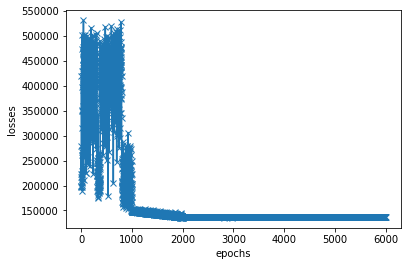

In [46]:
val_loss = [result] + history1 + history2 + history3 + history4 + history5+ history6
print(val_loss)
val_loss_list = [vl['val_loss'] for vl in val_loss]

plt.plot(val_loss_list, '-x')

plt.xlabel('epochs')
plt.ylabel('losses')

[{'val_loss': 418775.90625}, {'val_loss': 278389.5625}, {'val_loss': 198785.125}, {'val_loss': 198140.546875}, {'val_loss': 216332.828125}, {'val_loss': 197502.421875}, {'val_loss': 223243.59375}, {'val_loss': 260876.34375}, {'val_loss': 212449.546875}, {'val_loss': 216889.796875}, {'val_loss': 228194.03125}, {'val_loss': 271060.0}, {'val_loss': 200868.46875}, {'val_loss': 208038.125}, {'val_loss': 205763.328125}, {'val_loss': 197703.40625}, {'val_loss': 222685.59375}, {'val_loss': 266813.59375}, {'val_loss': 221448.34375}, {'val_loss': 189276.03125}, {'val_loss': 501173.0}, {'val_loss': 473315.0}, {'val_loss': 314661.3125}, {'val_loss': 349822.28125}, {'val_loss': 351636.9375}, {'val_loss': 429288.09375}, {'val_loss': 397675.6875}, {'val_loss': 410943.15625}, {'val_loss': 233037.546875}, {'val_loss': 452343.4375}, {'val_loss': 466514.40625}, {'val_loss': 350387.75}, {'val_loss': 390941.25}, {'val_loss': 408485.34375}, {'val_loss': 404120.65625}, {'val_loss': 358530.40625}, {'val_loss'

Text(0, 0.5, 'losses')

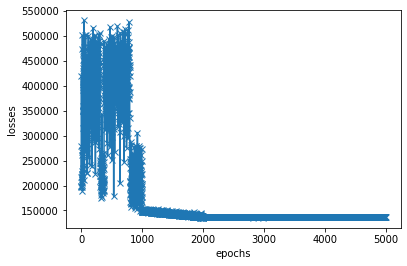

In [47]:
val_loss = [result] + history1 + history2 + history3 + history4 + history5
print(val_loss)
val_loss_list = [vl['val_loss'] for vl in val_loss]

plt.plot(val_loss_list, '-x')

plt.xlabel('epochs')
plt.ylabel('losses')

In [48]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [49]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([2.5000e+02, 6.3110e+03, 3.0000e+00, 5.9100e+01, 4.0000e+00, 2.0000e+00])
Target: tensor([373000.])
Prediction: tensor([348185.1562])


In [50]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([0.0000e+00, 7.8650e+03, 2.0000e+00, 3.8500e+01, 3.0000e+00, 1.0000e+00])
Target: tensor([302800.])
Prediction: tensor([363416.5625])


In [51]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([0.0000e+00, 5.5200e+03, 3.0000e+00, 6.9750e+01, 5.0000e+00, 5.0000e+00])
Target: tensor([385000.])
Prediction: tensor([340711.5625])


In [52]:
# Test-A

def predict_test_single(input, model):
    
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    
    #print("Input:", input)
    #print("Out:", prediction)
    return prediction.numpy()[0]
    
predictions=[]
for num, (xb, yb) in enumerate(test_ds):
    print(xb, yb)
    predictions.append(predict_test_single(xb, model))

for pred in predictions:
    print(pred)

tensor([0.0000e+00, 6.9380e+03, 3.0000e+00, 6.1990e+01, 7.0000e+00, 2.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 6.0780e+03, 4.0000e+00, 6.4000e+01, 4.0000e+00, 0.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 6.1500e+03, 3.0000e+00, 5.1150e+01, 5.0000e+00, 0.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([ 3.5000e+02,  9.3730e+03,  2.0000e+00,  4.5770e+01,  7.0000e+00,
        -2.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 7.2000e+03, 2.0000e+00, 4.4360e+01, 1.3000e+01, 5.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 6.1790e+03, 4.0000e+00, 9.2900e+01, 2.0000e+00, 2.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([4.5000e+02, 6.2920e+03, 2.0000e+00, 4.4500e+01, 4.0000e+00, 1.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 5.1130e+03, 4.0000e+00, 8.0000e+01, 1.0000e+00, 0.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([2.0000e+01, 5.3190e+03, 4.0000e+00, 7.6130e+01, 3.0000e+00

tensor([6.5000e+02, 5.2380e+03, 3.0000e+00, 6.3000e+01, 4.0000e+00, 4.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 8.0000e+03, 3.0000e+00, 8.9880e+01, 2.0000e+00, 1.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 7.7110e+03, 4.0000e+00, 8.9350e+01, 2.0000e+00, 0.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 6.2560e+03, 2.0000e+00, 4.3000e+01, 1.0000e+01, 3.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([3.3000e+02, 5.0000e+03, 4.0000e+00, 1.1000e+02, 4.0000e+00, 4.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([7.5000e+00, 6.4000e+03, 4.0000e+00, 5.5050e+01, 8.0000e+00, 6.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 7.6620e+03, 1.0000e+00, 3.0150e+01, 4.0000e+00, 0.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([4.2000e+02, 9.9750e+03, 2.0000e+00, 4.0000e+01, 5.0000e+00, 3.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 6.7760e+03, 4.0000e+00, 9.1500e+01, 2.0000e+00, 1.0000e+00])

tensor([4.5000e+02, 6.5220e+03, 3.0000e+00, 1.1500e+02, 3.0000e+00, 1.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([2.4000e+02, 8.5120e+03, 1.0000e+00, 3.1920e+01, 6.0000e+00, 2.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 5.3980e+03, 3.0000e+00, 5.9100e+01, 4.0000e+00, 4.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([3.5000e+02, 6.5150e+03, 2.0000e+00, 4.3000e+01, 5.0000e+00, 4.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([2.5000e+02, 8.0000e+03, 2.0000e+00, 5.0000e+01, 0.0000e+00, 2.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([9.0000e+00, 7.6500e+03, 2.0000e+00, 4.4100e+01, 0.0000e+00, 4.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 5.6730e+03, 2.0000e+00, 5.2000e+01, 4.0000e+00, 1.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 7.8000e+03, 5.0000e+00, 1.2120e+02, 4.0000e+00, 3.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([5.9000e+02, 7.6100e+03, 3.0000e+00, 5.9000e+01, 4.0000e+00, 2.0000e+00])

tensor([0.0000e+00, 8.0000e+03, 4.0000e+00, 5.7900e+01, 5.0000e+00, 1.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([4.0000e+02, 7.2240e+03, 2.0000e+00, 4.9000e+01, 4.0000e+00, 4.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([7.0000e+00, 6.5700e+03, 2.0000e+00, 4.3360e+01, 7.0000e+00, 0.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 9.2410e+03, 2.0000e+00, 5.4000e+01, 0.0000e+00, 1.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([ 0.0000e+00,  5.7690e+03,  3.0000e+00,  6.5000e+01,  0.0000e+00,
        -2.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 7.0000e+03, 2.0000e+00, 3.8460e+01, 0.0000e+00, 5.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 6.7500e+03, 3.0000e+00, 4.6800e+01, 0.0000e+00, 0.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 5.8880e+03, 3.0000e+00, 5.4340e+01, 3.0000e+00, 0.0000e+00]) tensor([0.], dtype=torch.float64)
tensor([0.0000e+00, 1.1000e+04, 4.0000e+00, 9.0000e+01, 7.0000e+00

376729.66
349602.47
326385.03
432767.78
350756.78
411193.66
318170.4
346587.56
346294.75
347273.38
368009.38
329623.1
344181.03
303154.8
344245.38
372289.97
501014.06
236075.17
375513.8
461334.6
362352.06
354237.8
405933.62
390799.6
465280.06
352591.84
456838.38
374409.47
409478.44
328730.2
354366.12
331549.16
382386.06
492335.4
360291.7
400162.94
316185.97
339600.88
373101.25
393862.66
370533.38
335960.47
391310.12
326553.7
387919.7
319645.28
301228.38
310298.25
352201.72
393486.06
373057.34
420265.5
469926.3
329314.6
334363.78
396126.84
377827.56
442446.12
325099.0
361071.2
321561.7
369454.7
372355.7
469826.06
322951.62
431681.1
408363.38
356325.03
365458.88
369186.47
308924.84
344481.7
358213.38
334299.25
422045.84
404209.94
360556.06
352012.97
352591.84
371434.78
454911.12
429080.06
384521.5
350263.38
348405.56
443197.56
342670.6
264786.44
355768.94
324302.44
365369.9
321211.7
349843.16
292576.25
318825.25
434671.12
456035.12
295784.94
348430.44
311755.9
345941.12
354949.34
320538.

In [54]:
dev_predictions=[]
for num, (xb, yb) in enumerate(val_ds):
    print(xb, yb)
    dev_predictions.append(predict_test_single(xb, model))

for pred in dev_predictions:
    print(pred)

tensor([2.5000e+02, 6.3110e+03, 3.0000e+00, 5.9100e+01, 4.0000e+00, 2.0000e+00]) tensor([373000.])
tensor([0.0000e+00, 7.8680e+03, 2.0000e+00, 3.8000e+01, 1.2000e+01, 4.0000e+00]) tensor([299000.])
tensor([6.5000e+02, 5.7170e+03, 3.0000e+00, 6.3840e+01, 4.0000e+00, 4.0000e+00]) tensor([365000.])
tensor([3.5900e+02, 7.3800e+03, 4.0000e+00, 5.0000e+01, 1.0000e+01, 1.0000e+01]) tensor([369000.])
tensor([0.0000e+00, 7.3730e+03, 3.0000e+00, 6.5620e+01, 3.0000e+00, 1.0000e+00]) tensor([483791.])
tensor([0.0000e+00, 4.4790e+03, 5.0000e+00, 9.6000e+01, 2.0000e+00, 2.0000e+00]) tensor([430000.])
tensor([5.0000e+02, 6.5000e+03, 3.0000e+00, 4.8000e+01, 4.0000e+00, 4.0000e+00]) tensor([312000.])
tensor([4.5000e+02, 7.4910e+03, 3.0000e+00, 5.3000e+01, 4.0000e+00, 4.0000e+00]) tensor([397000.])
tensor([0.0000e+00, 6.9500e+03, 2.0000e+00, 4.3550e+01, 6.0000e+00, 4.0000e+00]) tensor([302672.])
tensor([3.6800e+02, 6.6330e+03, 2.0000e+00, 4.9000e+01, 3.0000e+00, 1.0000e+00]) tensor([325000.])
tensor([0.

tensor([3.0000e+02, 4.8970e+03, 3.0000e+00, 6.8000e+01, 5.0000e+00, 5.0000e+00]) tensor([333000.])
tensor([0.0000e+00, 7.3400e+03, 2.0000e+00, 4.7000e+01, 0.0000e+00, 2.0000e+00]) tensor([345000.])
tensor([3.0000e+02, 6.9170e+03, 2.0000e+00, 5.0600e+01, 4.0000e+00, 3.0000e+00]) tensor([350000.])
tensor([0.0000e+00, 7.1000e+03, 2.0000e+00, 4.1970e+01, 7.0000e+00, 1.0000e+00]) tensor([297987.])
tensor([0.0000e+00, 8.7480e+03, 1.0000e+00, 3.3230e+01, 4.0000e+00, 2.0000e+00]) tensor([290696.0312])
tensor([0.0000e+00, 8.9640e+03, 1.0000e+00, 3.2750e+01, 4.0000e+00, 2.0000e+00]) tensor([293571.])
tensor([5.5000e+02, 6.6520e+03, 2.0000e+00, 6.9000e+01, 4.0000e+00, 3.0000e+00]) tensor([459000.])
tensor([0.0000e+00, 8.4200e+03, 2.0000e+00, 4.2160e+01, 6.0000e+00, 6.0000e+00]) tensor([355000.])
tensor([4.9700e+02, 6.3700e+03, 2.0000e+00, 4.2230e+01, 1.0000e+01, 3.0000e+00]) tensor([269000.])
tensor([0.0000e+00, 7.2630e+03, 2.0000e+00, 4.7500e+01, 0.0000e+00, 2.0000e+00]) tensor([345000.])
tensor

tensor([0.0000e+00, 6.4920e+03, 3.0000e+00, 5.9000e+01, 4.0000e+00, 0.0000e+00]) tensor([383000.])
tensor([0.0000e+00, 8.8000e+03, 2.0000e+00, 4.0420e+01, 6.0000e+00, 2.0000e+00]) tensor([355696.])
tensor([4.7000e+02, 5.9290e+03, 3.0000e+00, 4.2000e+01, 4.0000e+00, 4.0000e+00]) tensor([249000.])
tensor([0.0000e+00, 6.7740e+03, 3.0000e+00, 5.3000e+01, 4.0000e+00, 3.0000e+00]) tensor([359000.])
tensor([2.5000e+02, 1.0214e+04, 2.0000e+00, 4.2000e+01, 5.0000e+00, 5.0000e+00]) tensor([429000.])
tensor([4.6000e+02, 1.0195e+04, 2.0000e+00, 5.9340e+01, 5.0000e+00, 1.0000e+00]) tensor([605000.])
tensor([0.0000e+00, 7.8110e+03, 2.0000e+00, 4.1730e+01, 4.0000e+00, 0.0000e+00]) tensor([325949.])
tensor([5.2000e+02, 5.6670e+03, 3.0000e+00, 6.0000e+01, 4.0000e+00, 4.0000e+00]) tensor([340000.])
tensor([5.9900e+02, 5.6760e+03, 3.0000e+00, 7.4000e+01, 4.0000e+00, 3.0000e+00]) tensor([420000.])
tensor([0.0000e+00, 4.7500e+03, 6.0000e+00, 1.2194e+02, 2.0000e+00, 0.0000e+00]) tensor([579215.])
tensor([0.

tensor([3.9000e+02, 7.7060e+03, 2.0000e+00, 3.8800e+01, 4.0000e+00, 4.0000e+00]) tensor([299000.])
tensor([5.5000e+02, 5.3050e+03, 4.0000e+00, 9.9900e+01, 4.0000e+00, 3.0000e+00]) tensor([530000.])
tensor([0.0000e+00, 6.9900e+03, 3.0000e+00, 5.6750e+01, 4.0000e+00, 4.0000e+00]) tensor([396683.])
tensor([0.0000e+00, 6.8540e+03, 2.0000e+00, 4.8000e+01, 1.5000e+01, 1.2000e+01]) tensor([329000.])
tensor([0.0000e+00, 8.4240e+03, 2.0000e+00, 4.9960e+01, 4.0000e+00, 1.0000e+00]) tensor([420863.])
tensor([2.0000e+02, 6.9370e+03, 2.0000e+00, 4.3100e+01, 4.0000e+00, 4.0000e+00]) tensor([299000.])
tensor([0.0000e+00, 9.8000e+03, 1.0000e+00, 2.8210e+01, 4.0000e+00, 3.0000e+00]) tensor([276458.])
tensor([0.0000e+00, 7.9000e+03, 2.0000e+00, 4.4340e+01, 4.0000e+00, 1.0000e+00]) tensor([350286.])
tensor([4.8000e+02, 1.0000e+04, 2.0000e+00, 5.1500e+01, 1.6000e+01, 1.2000e+01]) tensor([515000.])
tensor([0.0000e+00, 7.0000e+03, 3.0000e+00, 4.8810e+01, 7.0000e+00, 2.0000e+00]) tensor([341670.])
tensor([3.

tensor([0.0000e+00, 6.7500e+03, 3.0000e+00, 5.1000e+01, 5.0000e+00, 0.0000e+00]) tensor([344250.])
tensor([0.0000e+00, 4.0820e+03, 3.0000e+00, 9.8000e+01, 0.0000e+00, 0.0000e+00]) tensor([400000.])
tensor([3.4000e+02, 7.2390e+03, 3.0000e+00, 6.7000e+01, 8.0000e+00, 4.0000e+00]) tensor([485000.])
tensor([0.0000e+00, 8.8350e+03, 3.0000e+00, 6.1530e+01, 5.0000e+00, 2.0000e+00]) tensor([543617.])
tensor([2.8000e+02, 7.8630e+03, 2.0000e+00, 3.5100e+01, 3.0000e+00, 3.0000e+00]) tensor([276000.])
tensor([0.0000e+00, 7.5000e+03, 2.0000e+00, 5.7120e+01, 0.0000e+00, 1.0000e+00]) tensor([428400.])
tensor([0.0000e+00, 6.7500e+03, 3.0000e+00, 5.3380e+01, 6.0000e+00, 1.0000e+00]) tensor([360315.])
tensor([7.7500e+02, 5.8910e+03, 3.0000e+00, 1.0100e+02, 1.0000e+00, 0.0000e+00]) tensor([595000.])
tensor([3.8000e+02, 5.7380e+03, 3.0000e+00, 1.0370e+02, 4.0000e+00, 0.0000e+00]) tensor([595000.])
tensor([0.0000e+00, 6.7890e+03, 3.0000e+00, 7.8800e+01, 4.0000e+00, 1.0000e+00]) tensor([535000.])
tensor([0.

In [69]:
# SAVE TO test-A/out.tsv 
import csv
with open('./test-A/out.tsv', 'wt') as f:
    writer = csv.writer(f, delimiter='\t')
    for row in predictions:
        writer.writerow([row])

In [64]:
# SAVE TO dev-0/out.tsv 

with open('./dev-0/out.tsv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    for row in list(dev_predictions):
        writer.writerow([row])

Error: iterable expected, not numpy.float32